In [85]:
from nltk.tokenize import word_tokenize
from collections import Counter
from operator import itemgetter
from tqdm import tqdm_notebook as tqdm

import numpy as np
import time
import tensorflow as tf
import pickle
import numpy as np
import time
import helper

# Load data

In [86]:
source_path = '../data/letters_source.txt'
target_path = '../data/letters_target.txt'

source_sentences = helper.load_data(source_path)
target_sentences = helper.load_data(target_path)

# Preprocessing

In [90]:
def extract_character_vocab(data):
    special_words = ['<PAD>', '<UNK>', '<GO>',  '<EOS>']

    set_words = sorted(list(set([character for line in data.split('\n') for character in line])))
    int_to_vocab = {word_i: word for word_i, word in enumerate(special_words + set_words)}
    vocab_to_int = {word: word_i for word_i, word in int_to_vocab.items()}

    return int_to_vocab, vocab_to_int

# Build int2letter and letter2int dicts
source_int_to_letter, source_letter_to_int = extract_character_vocab(source_sentences)
target_int_to_letter, target_letter_to_int = extract_character_vocab(target_sentences)
print(source_sentences[:10])
print(source_int_to_letter)
# print(source_letter_to_int)
# Convert characters to ids
source_letter_ids = [[source_letter_to_int.get(letter, source_letter_to_int['<UNK>']) for letter in line] for line in source_sentences.split('\n')]
target_letter_ids = [[target_letter_to_int.get(letter, target_letter_to_int['<UNK>']) for letter in line] + [target_letter_to_int['<EOS>']] for line in target_sentences.split('\n')] 

print("Example source sequence")
print(source_letter_ids[:3])
print("\n")
print("Example target sequence")
print(target_letter_ids[:3])

bsaqq
npy

{0: '<PAD>', 1: '<UNK>', 2: '<GO>', 3: '<EOS>', 4: 'a', 5: 'b', 6: 'c', 7: 'd', 8: 'e', 9: 'f', 10: 'g', 11: 'h', 12: 'i', 13: 'j', 14: 'k', 15: 'l', 16: 'm', 17: 'n', 18: 'o', 19: 'p', 20: 'q', 21: 'r', 22: 's', 23: 't', 24: 'u', 25: 'v', 26: 'w', 27: 'x', 28: 'y', 29: 'z'}
Example source sequence
[[5, 22, 4, 20, 20], [17, 19, 28], [15, 5, 26, 24, 13]]


Example target sequence
[[4, 5, 20, 20, 22, 3], [17, 19, 28, 3], [5, 13, 15, 24, 26, 3]]


In [42]:
from distutils.version import LooseVersion
import tensorflow as tf
from tensorflow.python.layers.core import Dense


# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.1'), 'Please use TensorFlow version 1.1 or newer'
print('TensorFlow Version: {}'.format(tf.__version__))

TensorFlow Version: 1.10.0


# Seq2seq with attention mechanism

In [58]:
class seq2seq_attention_model():
    def __init__(self, 
                 source_letter_to_int, 
                 target_letter_to_int,
                 batch_size,
                 enc_embed_size,
                 dec_embed_size,
                 enc_rnn_size,
                 dec_rnn_size,
                 enc_num_layers,
                 dec_num_layers,
                 attention_units_size,
                 learning_rate):
        
        self.source_letter_to_int = source_letter_to_int
        self.target_letter_to_int = target_letter_to_int
        
        self.batch_size = batch_size
        self.enc_embed_size = enc_embed_size
        self.dec_embed_size = dec_embed_size
        self.enc_rnn_size = enc_rnn_size
        self.dec_rnn_size = dec_rnn_size
        self.enc_num_layers = enc_num_layers
        self.dec_num_layers = dec_num_layers
        self.attention_units_size = attention_units_size
        self.learning_rate = learning_rate
    
    def encoder(self, sources, source_length):
        enc_embed_input = tf.contrib.layers.embed_sequence(ids=sources, 
                                                           vocab_size=len(self.source_letter_to_int), 
                                                           embed_dim=self.enc_embed_size)

        enc_cells = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.LSTMCell(self.enc_rnn_size, initializer=tf.random_uniform_initializer(-0.1,0.1,seed=2)) for _ in range(self.enc_num_layers)])
    
        enc_output, enc_state = tf.nn.dynamic_rnn(cell=enc_cells, 
                                                  inputs=enc_embed_input, 
                                                  sequence_length=source_length,
                                                  dtype=tf.float32)
        
        return enc_output, enc_state
    
    def process_dec_input(self, targets):
        ending = tf.strided_slice(targets, begin=[0,0], end=[self.batch_size,-1], strides=[1,1])
        fill_value = tf.fill(dims=[self.batch_size,1], value=self.target_letter_to_int['<GO>'])
        dec_input = tf.concat([fill_value, ending], axis=1)
        return dec_input
    
    def decoder(self, dec_input, enc_output, enc_state, source_length, target_length, max_target_length, attention):
        dec_embeddings = tf.Variable(tf.random_uniform([len(self.target_letter_to_int), self.dec_embed_size]))
        dec_embed_input = tf.nn.embedding_lookup(params=dec_embeddings, ids=dec_input)
        
        dec_cells = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.LSTMCell(self.dec_rnn_size, initializer=tf.random_uniform_initializer(-0.1,0.1,seed=2)) for _ in range(self.dec_num_layers)])
        
        # Attention
        """
        tensorflow實現的attention mechanism有兩種
        1. Bahdanau (就是 Neural machine translation by jointly learning to align and translate 的作者)
        attention的鼻祖，使用一層NN來學習attention weight
        
        2. Luong (Effective approaches to attention-based neural machine translation)
        改良attention weight的產生方式，有dot, general以及concat三種
        """
        if attention is 'Luong':
            attention_mechanism = tf.contrib.seq2seq.LuongAttention(num_units=self.attention_units_size, 
                                                                    memory=enc_output, 
                                                                    memory_sequence_length=source_length)
        else:
            attention_mechanism = tf.contrib.seq2seq.BahdanauAttention(num_units=self.attention_units_size,
                                                                       memory=enc_output,
                                                                       memory_sequence_length=source_length)
        
        attn_cell = tf.contrib.seq2seq.AttentionWrapper(cell=dec_cells,attention_layer_size=self.dec_rnn_size/2,
                                                        attention_mechanism=attention_mechanism,
                                                        alignment_history=True,
                                                        output_attention=True)
        
        output_layer = tf.layers.Dense(len(self.target_letter_to_int), kernel_initializer=tf.truncated_normal_initializer(mean=0.0,stddev=0.1))
        
        initial_state = attn_cell.zero_state(batch_size=self.batch_size, dtype=tf.float32).clone(cell_state=enc_state)
        
        # Training
        with tf.variable_scope('decoder'):

            training_helper = tf.contrib.seq2seq.TrainingHelper(inputs=dec_embed_input, 
                                                                sequence_length=target_length)
            training_decoder = tf.contrib.seq2seq.BasicDecoder(cell=attn_cell, 
                                                               helper=training_helper, 
                                                               initial_state=initial_state,
                                                               output_layer=output_layer)
            train_logits, train_final_state, train_final_sequence_lengths = tf.contrib.seq2seq.dynamic_decode(decoder=training_decoder)

            self.train_attention_metrices = train_final_state.alignment_history.stack(name='training_attention_metrices')
        
        # Inference
        with tf.variable_scope('decoder', reuse=True):
            start_tokens = tf.tile(tf.constant([self.target_letter_to_int['<GO>']],dtype=tf.int32), [self.batch_size])
            end_token = self.target_letter_to_int['<EOS>']
            inference_helper = tf.contrib.seq2seq.GreedyEmbeddingHelper(embedding=dec_embeddings, 
                                                                        start_tokens=start_tokens, 
                                                                        end_token=end_token)
            inference_decoder = tf.contrib.seq2seq.BasicDecoder(cell=attn_cell,
                                                                helper=inference_helper,
                                                                initial_state=initial_state,
                                                                output_layer=output_layer)

            inference_logits, inference_final_state, _ = tf.contrib.seq2seq.dynamic_decode(decoder=inference_decoder,
                                                                                           output_time_major=False,
                                                                                           impute_finished=True,
                                                                                           maximum_iterations=max_target_length)
            self.inference_attention_metrices = inference_final_state.alignment_history.stack(name='inference_attention_metrices')
        
        return train_logits, inference_logits
    
    def compute_loss(self, train_logits, inference_logits, target_length, max_target_length):
        self.training_logits = tf.identity(train_logits.rnn_output, name='logits')
        self.predict_logits = tf.identity(inference_logits.sample_id, name='predictions')
        
        masks = tf.sequence_mask(target_length, max_target_length, dtype=tf.float32, name='masks')
        
        self.loss = tf.contrib.seq2seq.sequence_loss(logits=self.training_logits, targets=targets, weights=masks)
        
        optimizer = tf.train.AdamOptimizer(self.learning_rate)
        
        gradients = optimizer.compute_gradients(self.loss)
        capped_gradients = [(tf.clip_by_value(grad, -5., 5.), var) for grad, var in gradients if grad is not None]
        self.train_op = optimizer.apply_gradients(capped_gradients)
        

# Parameters

In [59]:
epochs = 100
batch_size = 128
learning_rate = 0.001

enc_embed_size = 15
dec_embed_size = 15

enc_rnn_size = 50
dec_rnn_size = 50

enc_num_layers = 2
dec_num_layers = 2

attention_units_size = 50

# Define graph

In [60]:
tf.reset_default_graph()
graph = tf.Graph()
with graph.as_default(): 
    sources = tf.placeholder(shape=[None, None], dtype=tf.int32, name='sources')
    targets = tf.placeholder(shape=[None, None], dtype=tf.int32, name='targets')
        
    source_length = tf.placeholder(shape=[None,], dtype=tf.int32, name='source_length')
    target_length = tf.placeholder(shape=[None,], dtype=tf.int32, name='target_length')
    max_target_length = tf.reduce_max(target_length, name='max_target_length')
        
    seq2seq_attn = seq2seq_attention_model(source_letter_to_int, 
                                           target_letter_to_int, 
                                           batch_size, 
                                           enc_embed_size,
                                           dec_embed_size,
                                           enc_rnn_size,
                                           dec_rnn_size,
                                           enc_num_layers,
                                           dec_num_layers,
                                           attention_units_size,
                                           learning_rate)
    enc_output, enc_state = seq2seq_attn.encoder(sources, source_length)
    dec_input = seq2seq_attn.process_dec_input(targets)
    train_logits, inference_logits = seq2seq_attn.decoder(dec_input, enc_output, enc_state, source_length, target_length, max_target_length, attention='Bahdanau')
    seq2seq_attn.compute_loss(train_logits, inference_logits, target_length, max_target_length)

# Padding

In [61]:
def pad_sentence_batch(sentence_batch, pad_int):
    """Pad sentences with <PAD> so that each sentence of a batch has the same length"""
    max_sentence = max([len(sentence) for sentence in sentence_batch]) 
    return [sentence + [pad_int] * (max_sentence - len(sentence)) for sentence in sentence_batch]

In [62]:
def get_batches(targets, sources, batch_size, source_pad_int, target_pad_int):
    """Batch targets, sources, and the lengths of their sentences together"""
    for batch_i in range(0, len(sources)//batch_size):
        start_i = batch_i * batch_size
        sources_batch = sources[start_i:start_i + batch_size]
        targets_batch = targets[start_i:start_i + batch_size]
        sources_pad_batch = np.array(pad_sentence_batch(sources_batch, source_pad_int))
        targets_pad_batch = np.array(pad_sentence_batch(targets_batch, target_pad_int))
        
        # Need the lengths for the _lengths parameters
        source_batch_length = [len(sequence) for sequence in sources_batch]
        target_batch_length = [len(sequence) for sequence in targets_batch]
        
        yield sources_pad_batch, targets_pad_batch, source_batch_length, target_batch_length

# Training step

In [48]:
train_source = source_letter_ids[batch_size:]
train_target = target_letter_ids[batch_size:]
valid_source = source_letter_ids[:batch_size]
valid_target = target_letter_ids[:batch_size]
(valid_sources_batch, valid_targets_batch, valid_sources_lengths, valid_targets_lengths) = next(get_batches(valid_target, valid_source, batch_size,
                           source_letter_to_int['<PAD>'],
                           target_letter_to_int['<PAD>']))


checkpoint = "attention_model/best_model.ckpt"
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())

    total_train_loss = []
    total_valid_loss = []
    total_batch = len(train_source) // batch_size
    
    for epoch_i in range(1, epochs+1):
        
        start = time.time()
        train_loss = []
        valid_loss = []
        for batch_i, (sources_batch, targets_batch, sources_lengths, targets_lengths) in enumerate(
                get_batches(train_target, train_source, batch_size,
                           source_letter_to_int['<PAD>'],
                           target_letter_to_int['<PAD>'])):
            # Training step
            _, loss_, train_attn = sess.run(
                [seq2seq_attn.train_op, seq2seq_attn.loss,
                 seq2seq_attn.train_attention_metrices],
                {sources: sources_batch,
                 targets: targets_batch,
                 target_length: targets_lengths,
                 source_length: sources_lengths})
            
            train_loss.append(loss_)
            

                
        # Calculate validation cost
        validation_loss = sess.run(seq2seq_attn.loss,{sources: valid_sources_batch,
                                                      targets: valid_targets_batch,
                                                      target_length: valid_targets_lengths,
                                                      source_length: valid_sources_lengths})
        valid_loss.append(validation_loss)
        
        train_loss = np.mean(train_loss)
        
        total_train_loss.append(train_loss)
        total_valid_loss.append(valid_loss)
        
        print('Epoch %d/%d train_loss: %.4f, valid_loss: %.4f' % (epoch_i,epochs, train_loss, validation_loss))
        print(time.time() - start)

    
    
    # Save Model
    saver = tf.train.Saver()
    saver.save(sess, checkpoint)
    print('Model Trained')

Epoch 1/100 train_loss: 3.0095, valid_loss: 2.5948
2.492288112640381
Epoch 2/100 train_loss: 2.2191, valid_loss: 1.9515
1.667057991027832
Epoch 3/100 train_loss: 1.8172, valid_loss: 1.6755
1.663804292678833
Epoch 4/100 train_loss: 1.5682, valid_loss: 1.4489
1.6812083721160889
Epoch 5/100 train_loss: 1.3193, valid_loss: 1.2593
1.6800501346588135
Epoch 6/100 train_loss: 1.1622, valid_loss: 1.1346
1.680969476699829
Epoch 7/100 train_loss: 1.0530, valid_loss: 1.0211
1.662083387374878
Epoch 8/100 train_loss: 0.9505, valid_loss: 0.9203
1.6908199787139893
Epoch 9/100 train_loss: 0.8493, valid_loss: 0.8187
1.6761813163757324
Epoch 10/100 train_loss: 0.7435, valid_loss: 0.7102
1.6754069328308105
Epoch 11/100 train_loss: 0.6041, valid_loss: 0.5389
1.682664394378662
Epoch 12/100 train_loss: 0.4067, valid_loss: 0.3005
1.681976318359375
Epoch 13/100 train_loss: 0.2125, valid_loss: 0.1643
1.6579089164733887
Epoch 14/100 train_loss: 0.1155, valid_loss: 0.0984
1.6793882846832275
Epoch 15/100 train_los

# Predict

In [104]:
def source_to_seq(text):
    '''Prepare the text for the model'''
    sequence_length = 7
    return [source_letter_to_int.get(word, source_letter_to_int['<UNK>']) for word in text]+ [source_letter_to_int['<PAD>']]*(sequence_length-len(text))

In [119]:
input_sentence = 'lexa'
text = source_to_seq(input_sentence)

checkpoint = "model/best_model.ckpt"

loaded_graph = tf.Graph() # 建立靜態圖
with tf.Session(graph=loaded_graph) as sess:
    # Load saved model
    loader = tf.train.import_meta_graph(checkpoint + '.meta') # 載入先前訓練好的模型靜態圖
    loader.restore(sess, checkpoint) # 在sess中載入模型參數(weights, bias)

    input_data = loaded_graph.get_tensor_by_name('sources:0') # 載入input placeholder
    logits = loaded_graph.get_tensor_by_name('predictions:0') # 載入inference
    source_sequence_length = loaded_graph.get_tensor_by_name('source_length:0')
    target_sequence_length = loaded_graph.get_tensor_by_name('target_length:0')
    
    inference_attention_metrics = loaded_graph.get_tensor_by_name('decoder_1/inference_attention_metrices/inference_attention_metrices:0')
    
    #Multiply by batch_size to match the model's input parameters
    answer_logits, att = sess.run([logits, inference_attention_metrics], {input_data: [text]*batch_size,
                                      target_sequence_length: [len(input_sentence)]*batch_size,
                                      source_sequence_length: [len(input_sentence)]*batch_size})

INFO:tensorflow:Restoring parameters from model/best_model.ckpt


In [108]:
pad = source_letter_to_int["<PAD>"] 

print('Original Text:', input_sentence)

print('\nSource')
print('  Word Ids:    {}'.format([i for i in text]))
print('  Input Words: {}'.format(" ".join([source_int_to_letter[i] for i in text])))

print('\nTarget')
print('  Word Ids:       {}'.format([i for i in answer_logits if i != pad]))
print('  Response Words: {}'.format(" ".join([target_int_to_letter[i] for i in answer_logits if i != pad])))

Original Text: lexa

Source
  Word Ids:    [15, 8, 27, 4, 0, 0, 0]
  Input Words: l e x a <PAD> <PAD> <PAD>

Target
  Word Ids:       [4, 8, 15, 27]
  Response Words: a e l x


In [152]:
att.shape # (output_len, batch_size, maxlen)

(4, 128, 7)

# Attention map visualization

In [182]:
import seaborn as sns
import pandas as pd
%matplotlib inline

In [179]:
att_map = pd.DataFrame(att[:,0,:], 
                       columns=[source_int_to_letter.get(t) for t in text], 
                       index=[target_int_to_letter.get(t) for t in answer_logits[0]])
att_map

,l,e,x,a,<PAD>,<PAD>,<PAD>
a,9.535641e-08,0.000579,0.003968,0.995453,0.0,0.0,0.0
e,2.730971e-05,0.999895,0.000001,0.000077,0.0,0.0,0.0
l,9.999098e-01,0.000071,0.000008,0.000011,0.0,0.0,0.0
x,7.102809e-05,0.000023,0.998766,0.001141,0.0,0.0,0.0


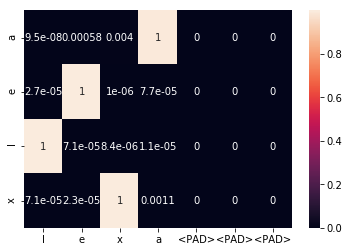

In [183]:
sns.heatmap(att_map, annot=True)
plt.show()